In [14]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import sys
import time

from util import *

## Load the COMPAS dataset

In [15]:
# Load COMPAS data
X,y,sensitive_features = load_compas_X_y_s(datasets)

# Split dataset into 4 sub-groups and retrieve the indices
subgroups_indices = get_lable_group_index(X, y, sensitive_features)

## Define a model for the study of long-term impact of fairness contraints in COMPAS

### Initial qualification rates
We randomly sample beginning points from 0 to 1. As shown in the following figure. 

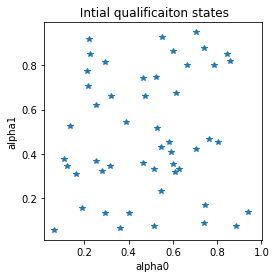

In [16]:
# Define the start point of qualification rates
np.random.seed(777)

NUM_SAMPLES = 50
P0 = 0.8
alpha0List = np.random.uniform(0.05,0.95,NUM_SAMPLES)
alpha1List = np.random.uniform(0.05,0.95,NUM_SAMPLES)


plt.ylim(0, 1)
plt.xlim(0, 1)
plt.plot(alpha0List,alpha1List,'*',label='Initial points')

plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.axis('square')
plt.title(" Intial qualificaiton states")
plt.show()

### Transition probability 
- The probability to be qualified given the current qualification state $Y_t=y$, decision $A_t = a$, and the group $S=s$, i.e., $P(Y_{t+1} = 1 \mid Y_t = y, A_t = a, S=s)$, is represented by an array T[ y, a, s].  
- The following defined transition is under Condition 1(ii) in the paper.


In [20]:
# Define the transition matrix 
# The order of index in T: 
# ["qualification state", "decision", "group"]
T = np.zeros((2, 2, 2))
T[0,0,0] = 0.3
T[0,1,0] = 0.5
T[1,0,0] = 0.5
T[1,1,0] = 0.7

T[0,0,1] = 0.1 # "Caucasian"
T[0,1,1] = 0.5
T[1,0,1] = 0.5
T[1,1,1] = 0.9


## The evolution trajectory of qualification states   

In this study, we consider the demographic invariant generation case. The generation distribution is not changed over time, but the ratio of different subgroups is changed, i.e., the qualification rate. Therefore, we can use resampling to get the dataset at each time step.

*The algorithm:*
1. Compute the ratio for each subgroup;  
2. Sample from the original dataset according to the subgroup-wised ratio;  
3. Apply a classifier to estimating the decision boundary;
4. Apply the dynamics to compute the ratio in next time step.
 

### Evolution behavior in the UN case
**Evolution behavior.** From one sample result, we can see the evolution behavior. The figure indicates that in the UN case, qualification rates converge to an unique equiibria.

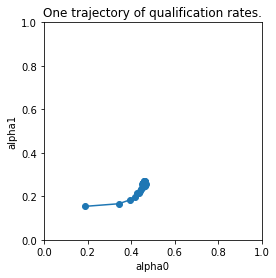

In [22]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 100

k=0
alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_un_evolution=[alpha0]
alpha1_un_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # Group-wise ratio
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # Sampling according to the group-wise ratios
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr_un,acc_un,tpr_un,fpr_un = eva_classifier(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_un_evolution.append(transition(alpha0,
                                          tpr_un["African-American"],
                                          fpr_un["African-American"],
                                          T, group = 0))

    alpha1_un_evolution.append(transition(alpha1,
                                          tpr_un["Caucasian"],fpr_un["Caucasian"],
                                          T, group = 1))

    alpha0 = alpha0_un_evolution[-1]
    alpha1 = alpha1_un_evolution[-1]

plt.figure()
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_un_evolution,alpha1_un_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates.")
plt.show()


**Equilibrium.** By study 50 different beginning points, we plot the last 5-interation results. It shows that there is one unique equilibria in the UN case.

49

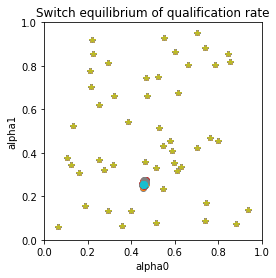

In [24]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_un_evolution=[alpha0]
    alpha1_un_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  
        
        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)
        
        # train (fair) classifiers
        pr_un,acc_un,tpr_un,fpr_un = eva_classifier(X_train,y_train,sensitive_features_train)
        
        # transitions
        alpha0_un_evolution.append(transition(alpha0,
                                              tpr_un["African-American"],
                                              fpr_un["African-American"],
                                              T, group = 0))
        
        alpha1_un_evolution.append(transition(alpha1,
                                              tpr_un["Caucasian"],fpr_un["Caucasian"],
                                              T, group = 1))

        alpha0 = alpha0_un_evolution[-1]
        alpha1 = alpha1_un_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_un_evolution[-5:],alpha1_un_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate")
plt.show()


### The DP case
**Evolution behavior.** The figure indicates that in the DP case, qualification rates converge to an unique equiibria.

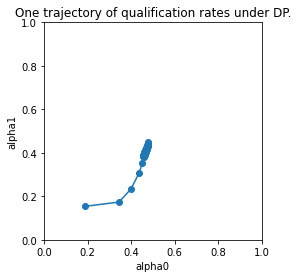

In [25]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_dp_evolution=[alpha0]
alpha1_dp_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_dp(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_dp_evolution.append(transition(alpha0,
                                          tpr["African-American"],
                                          fpr["African-American"],
                                          T, group = 0))

    alpha1_dp_evolution.append(transition(alpha1,
                                          tpr["Caucasian"],fpr["Caucasian"],
                                          T, group = 1))

    alpha0 = alpha0_dp_evolution[-1]
    alpha1 = alpha1_dp_evolution[-1]

plt.figure()
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_dp_evolution,alpha1_dp_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under DP.")
plt.show()


**Equilibrium.** By study 50 different beginning points, we plot the last 5-interation results. It shows that there is one unique equilibria in the DP case.

49

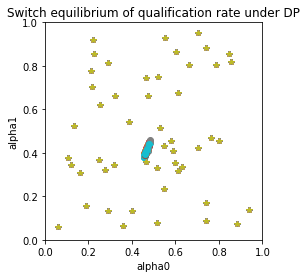

In [26]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_dp_evolution=[alpha0]
    alpha1_dp_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  
        
        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)
        
        # train (fair) classifiers
        pr,acc,tpr,fpr = eva_classifier_dp(X_train,y_train,sensitive_features_train)
        
        # transitions
        alpha0_dp_evolution.append(transition(alpha0,
                                              tpr["African-American"],
                                              fpr["African-American"],
                                              T, group = 0))
        
        alpha1_dp_evolution.append(transition(alpha1,
                                              tpr["Caucasian"],fpr["Caucasian"],
                                              T, group = 1))

        alpha0 = alpha0_dp_evolution[-1]
        alpha1 = alpha1_dp_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_dp_evolution[-5:],alpha1_dp_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate under DP")
plt.show()


### The EO case

**Evolution behavior.**The figure shows that two different samples didn't converge to any points even in 200 iterations.

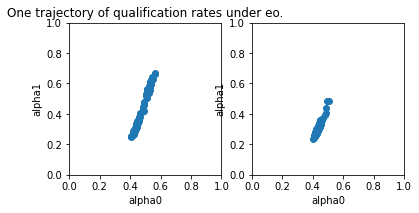

In [47]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 200

k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_eo_evolution=[alpha0]
alpha1_eo_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_eo(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_eo_evolution.append(transition(alpha0,tpr["African-American"],
                                             fpr["African-American"],
                                             T, group = 0))

    alpha1_eo_evolution.append(transition(alpha1,tpr["Caucasian"],
                                             fpr["Caucasian"],
                                             T, group = 1))

    alpha0 = alpha0_eo_evolution[-1]
    alpha1 = alpha1_eo_evolution[-1]

plt.figure()
plt.subplot(1,2,1)
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_eo_evolution[100:],alpha1_eo_evolution[100:],'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under eo.")

k=45

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_eo_evolution=[alpha0]
alpha1_eo_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_eo(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_eo_evolution.append(transition(alpha0,tpr["African-American"],
                                             fpr["African-American"],
                                             T, group = 0))

    alpha1_eo_evolution.append(transition(alpha1,tpr["Caucasian"],
                                             fpr["Caucasian"],
                                             T, group = 1))

    alpha0 = alpha0_eo_evolution[-1]
    alpha1 = alpha1_eo_evolution[-1]

plt.subplot(1,2,2)
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_eo_evolution[100:],alpha1_eo_evolution[100:],'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()



**Equilibrium.**  The results show that the qualifcation rates fluctuate in a range under EO policies.

49

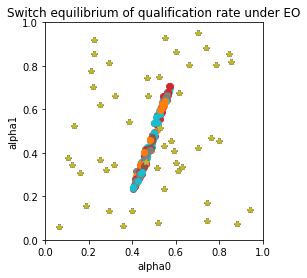

In [39]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 100

plt.figure()
NUM_SAMPLES = 10
for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))    
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eo_evolution=[alpha0]
    alpha1_eo_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

        # train (fair) classifiers
        pr,acc,tpr,fpr = eva_classifier_eo(X_train,y_train,sensitive_features_train)

        # transitions
        alpha0_eo_evolution.append(transition(alpha0,tpr["African-American"],
                                                 fpr["African-American"],
                                                 T, group = 0))

        alpha1_eo_evolution.append(transition(alpha1,tpr["Caucasian"],
                                                 fpr["Caucasian"],
                                                 T, group = 1))

        alpha0 = alpha0_eo_evolution[-1]
        alpha1 = alpha1_eo_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_eo_evolution[-5:],alpha1_eo_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate under EO")
plt.show()


### The EqOpt case
**Evolution behvior.** We find that in the EqOpt case, different beginning points converge to different points. There could be multiple equilibrium.

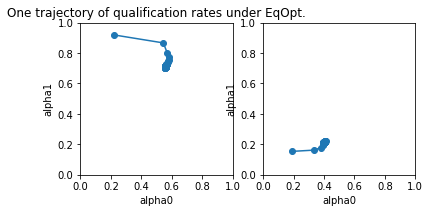

In [44]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 100

k=45

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_eqopt_evolution=[alpha0]
alpha1_eqopt_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_eqopt(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_eqopt_evolution.append(transition(alpha0,tpr["African-American"],
                                             fpr["African-American"],
                                             T, group = 0))

    alpha1_eqopt_evolution.append(transition(alpha1,tpr["Caucasian"],
                                             fpr["Caucasian"],
                                             T, group = 1))

    alpha0 = alpha0_eqopt_evolution[-1]
    alpha1 = alpha1_eqopt_evolution[-1]

plt.figure()
plt.subplot(1,2,1)
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_eqopt_evolution,alpha1_eqopt_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.title("One trajectory of qualification rates under EqOpt.")



k=0

alpha0, alpha1 =  alpha0List[k],alpha1List[k]
alpha0_eqopt_evolution=[alpha0]
alpha1_eqopt_evolution=[alpha1]
t = 0
while t < MAX_ITERATION_EQUILIBRIUM:
    t+=1
    # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
    ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

    # sample individuals from 4 sub-groups
    X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

    # train (fair) classifiers
    pr,acc,tpr,fpr = eva_classifier_eqopt(X_train,y_train,sensitive_features_train)

    # transitions
    alpha0_eqopt_evolution.append(transition(alpha0,tpr["African-American"],
                                             fpr["African-American"],
                                             T, group = 0))

    alpha1_eqopt_evolution.append(transition(alpha1,tpr["Caucasian"],
                                             fpr["Caucasian"],
                                             T, group = 1))

    alpha0 = alpha0_eqopt_evolution[-1]
    alpha1 = alpha1_eqopt_evolution[-1]
plt.subplot(1,2,2)
plt.axis('square')
plt.xlabel('alpha0')
plt.ylabel('alpha1')
plt.plot(alpha0_eqopt_evolution,alpha1_eqopt_evolution,'o-')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()



**Equilibrium.** The figure shows that there are two equilibrium in the case of EqOpt.

49

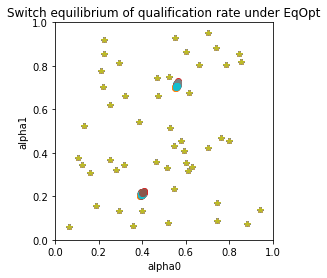

In [41]:
np.random.seed(777)
MAX_ITERATION_EQUILIBRIUM = 50

plt.figure()

for k in range(NUM_SAMPLES):
    sys.stdout.write("\r{0}".format(str(k)))
    alpha0, alpha1 =  alpha0List[k],alpha1List[k]
    alpha0_eqopt_evolution=[alpha0]
    alpha1_eqopt_evolution=[alpha1]
    t = 0
    while t < MAX_ITERATION_EQUILIBRIUM:
        t+=1
        # r_label0_group0,r_label0_group1,r_label1_group0,r_label1_group1 
        ratio = P0*(1-alpha0),(1-P0)*(1-alpha1),P0*alpha0,(1-P0)*alpha1  

        # sample individuals from 4 sub-groups
        X_train,y_train,sensitive_features_train = dataSelection(X,y,sensitive_features,subgroups_indices,ratio)

        # train (fair) classifiers
        pr,acc,tpr,fpr = eva_classifier_eqopt(X_train,y_train,sensitive_features_train)

        # transitions
        alpha0_eqopt_evolution.append(transition(alpha0,tpr["African-American"],
                                                 fpr["African-American"],
                                                 T, group = 0))

        alpha1_eqopt_evolution.append(transition(alpha1,tpr["Caucasian"],
                                                 fpr["Caucasian"],
                                                 T, group = 1))

        alpha0 = alpha0_eqopt_evolution[-1]
        alpha1 = alpha1_eqopt_evolution[-1]
    plt.axis('square')
    plt.plot(alpha0List,alpha1List,'*')
    plt.xlabel('alpha0')
    plt.ylabel('alpha1')
    plt.plot(alpha0_eqopt_evolution[-5:],alpha1_eqopt_evolution[-5:],'o',label='No.'+str(k))
    plt.ylim(0, 1)
    plt.xlim(0, 1)
plt.title("Switch equilibrium of qualification rate under EqOpt")
plt.show()
